Описание датасета

***Поля:***
* call_id: уникальный идентификатор звонка, UNIX время с точностью до 3-5 знаков после запятой;
* time_id: UNIX время поступления ивента
* agent: Анонимизированные имена операторов
* verb: Название ивента, описание приведено ниже
* data: Различные приложения к ивентам
* call_duration: Длительность звонка (если он завершен)
* queue_duration: Длительность ожидания клиентом ответа в очереди (если звонок не завершился в IVR, interactive voice response, голосовой ассистент)

***Ивенты (поле verb):***
* INFO: различные события в IVR, в частности изначальное прибытие звонка
* ENTERQUEUE: вход звонящего в очередь
* CONNECT: присоединение клиента к оператору
* ABANDON: клиент завершил звонок, находясь в очереди
* CALLERONHOLD/CALLEROFFHOLD: звонок был поставлен на удержание/снят с удержания оператором
* COMPLETECALLER/COMPLETEAGENT: звонок был завершен звонящим / оператором соответственно
Если verb = INFO, то в data могут содержаться следующие события:

* IVRSTART: момент начала звонка, клиент попадает в IVR.
* IVRAPPEND: ветка в IVR, куда нажимает клиент.
* IVRGOAL: цель звонка достигнута, т.е. клиент попал в нужную линию.За этим событием обязательно должно следовать ENTERQUEUE
* IVRHANGUP: звонок завершился в IVR

In [2]:
#импортируем библиотеки и т.д. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import sqlite3
import io

%matplotlib inline

sns.set(style="darkgrid", font_scale=1.0)
sns.set_palette("pastel")

pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('C:/Users/Zag-zag/Desktop/Аналитика КЦ.csv', sep = ',', index_col = 'Unnamed: 0')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427504 entries, 0 to 427503
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   call_id         427504 non-null  object 
 1   time_id         427504 non-null  int64  
 2   agent           427504 non-null  int64  
 3   verb            427504 non-null  object 
 4   data            369784 non-null  object 
 5   call_duration   21507 non-null   float64
 6   queue_duration  21507 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 26.1+ MB


In [6]:
df.head()

,call_id,time_id,agent,verb,data,call_duration,queue_duration
0,1630007244.297276,1630007295,0,INFO,IVRAPPEND,NaN,NaN
1,1630007263.297282,1630007288,0,INFO,IVRAPPEND,NaN,NaN
2,1630007235.297273,1630007288,0,INFO,IVRAPPEND,NaN,NaN
3,1630007226.297272,1630007282,0,INFO,IVRAPPEND,NaN,NaN
4,1630007263.297282,1630007281,0,INFO,IVRAPPEND,NaN,NaN


In [7]:
df.sample()

,call_id,time_id,agent,verb,data,call_duration,queue_duration
168086,REALTIME,1629644171,33,ADDMEMBER,PAUSED,NaN,NaN


In [8]:
#проверим кол-во уникальных значений
df.call_id.nunique(), df.time_id.nunique(), df.agent.nunique()

(48658, 301701, 72)

In [9]:
# првоерим распределение значений по агентам и ивентам
df.agent.value_counts()

0     338756
11      3033
7       2999
22      2886
5       2353
       ...  
68       161
66       111
69        80
70        56
55         8
Name: agent, Length: 72, dtype: int64

***Кол-во вхождения для agent 0 превышает все остальные в 10 раз.Из описания датасета мы понимаем что agent 0  это IVR. В будущем постараемся не учитывать его.***

In [8]:
df.verb.value_counts()

INFO              301247
ENTERQUEUE         24729
CONNECT            21670
COMPLETEAGENT      15262
PAUSE              13101
PAUSEREASON        12580
UNPAUSE            12110
COMPLETECALLER      6245
CALLERONHOLD        4646
CALLEROFFHOLD       4500
ABANDON             3884
REMOVEMEMBER        2976
ADDMEMBER           2968
CALLOUTBOUND         825
RINGNOANSWER         268
PAUSEALL             178
BLINDTRANSFER        166
RINGCANCELED         149
Name: verb, dtype: int64

In [10]:
# проверим наличие дубликатов. Видим что есть неопознанные id звонков.
df.loc[lambda df: df.duplicated()]

,call_id,time_id,agent,verb,data,call_duration,queue_duration
23,NONE,1630007248,2,UNPAUSE,NaN,NaN,NaN
24,NONE,1630007248,2,UNPAUSE,NaN,NaN,NaN
77,NONE,1630007055,3,PAUSEREASON,11,NaN,NaN
78,NONE,1630007055,3,PAUSE,NaN,NaN,NaN
79,NONE,1630007055,3,PAUSEREASON,11,NaN,NaN
...,...,...,...,...,...,...,...
427377,NONE,1629220719,40,UNPAUSE,NaN,NaN,NaN
427476,NONE,1629220467,42,PAUSEREASON,11,NaN,NaN
427477,NONE,1629220467,42,PAUSE,NaN,NaN,NaN
427478,NONE,1629220467,42,PAUSEREASON,11,NaN,NaN


In [11]:
# считаем количество неопознанных id  звонков
unind_calls = df.call_id.str.contains('[a-zA-Z]', regex = True).sum()
all = len(df['call_id'])

print(f'Количество неопонанных id звонков: {unind_calls}')
print(f'Отношение неопонанных id ко всем: {np.round((unind_calls/all)*100,2)}%')

unind_ids_df = df.loc[lambda df:df.call_id.str.contains('[a-zA-Z]', regex = True)]
unind_ids_df.call_id.value_counts()

Количество неопонанных id звонков: 43913
Отношение неопонанных id ко всем: 10.27%


NONE        32033
REALTIME    11880
Name: call_id, dtype: int64

***Изначально я хотел присвоить каждому неопознанному id  значение следующей ячейки -0.00001, но подумал что это можт только ухудшить наш анализ, потому что это будет очень ндостоверная информация.
Несмотря на достаточно большое значение низвестных id, было принято решение избавимся от неопознанных id***

In [12]:
clear_df = df.drop(unind_ids_df.index)
# после избавления от неизвестных id еще остались дубликаты. уберем их тоже
print(f'Количество дубликатов после удаления неизвестных id:{clear_df.duplicated().sum()}')
df = clear_df.drop_duplicates()
df.info()

Количество дубликатов после удаления неизвестных id:1959
<class 'pandas.core.frame.DataFrame'>
Int64Index: 381632 entries, 0 to 427503
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   call_id         381632 non-null  object 
 1   time_id         381632 non-null  int64  
 2   agent           381632 non-null  int64  
 3   verb            381632 non-null  object 
 4   data            351578 non-null  object 
 5   call_duration   21507 non-null   float64
 6   queue_duration  21507 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 23.3+ MB


In [13]:
# преобразуем unix в ts и вычленим дату, название дня недели, время и час, т.к. у нас все данные из одного месяца и года
df['ts'] = pd.to_datetime(df.loc[:, 'time_id'], infer_datetime_format=True, unit="s")
df['date'] = df['ts'].dt.date
df['weekday'] = df['ts'].dt.day_name()
df['time'] = df['ts'].dt.time
df['hour'] = df['ts'].dt.hour
df.ts.min(), df.ts.max()

(Timestamp('2021-08-13 21:00:02'), Timestamp('2021-08-31 20:59:54'))

### ***Что можно сказать о распределении количества звонков?***

- Распределение по дням неравномерное, нет линейной выраженности,  максимальное количество звонков - 14.08.21, 23.08.21, 28.08.21. В остальные дни количество звонков находится примерно на одном уровне.
- Распределение по дням недели показывает что основной наплыв звонков приодится на выходные - субботу и воскресенье. С понедельника начинается спад.
- распределение по часам показывает, что самые жаркие часы это с 11.00 до 19.00. Пик приходится на промежуток 15.00-18.00. Это подтверждается срезом дня 16.08.21 с медианным количеством звонков в этот день. 


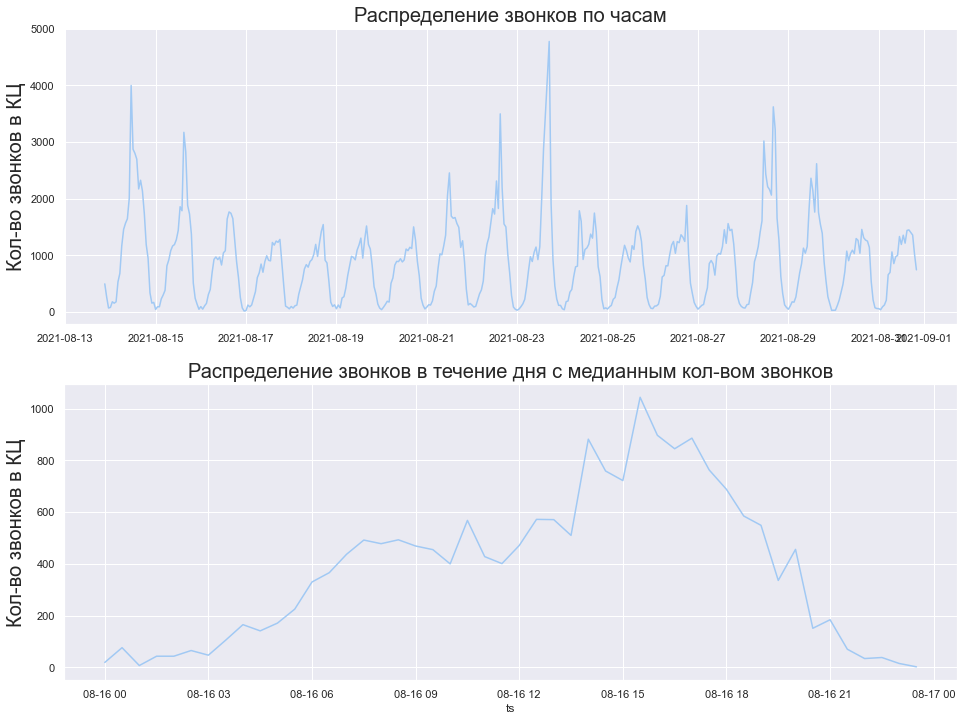

<Figure size 720x432 with 0 Axes>

In [19]:
f, axes = plt.subplots(2,1, figsize=(16, 12))
plt.figure(figsize=(10,6))

sns.lineplot(data = df.resample('1h', on = 'ts')['call_id'].count(), ax=axes[0])
axes[0].set_title('Распределение звонков по часам', fontsize = 20)
axes[0].set_ylabel('Кол-во звонков в КЦ', fontsize = 20)
axes[0].set_xlabel('')



sns.lineplot(data = df.query("ts >='2021-08-16 00:00:00' and ts < '2021-08-17 00:00:00'")\
                            .resample('30min', on = 'ts')['call_id'].count(), ax=axes[1])
axes[1].set_title('Распределение звонков в течение дня c медианным кол-вом звонков', fontsize = 20)
axes[1].set_ylabel('Кол-во звонков в КЦ', fontsize = 20)
f.subplots_adjust(hspace=0.2)
plt.tight_layout()


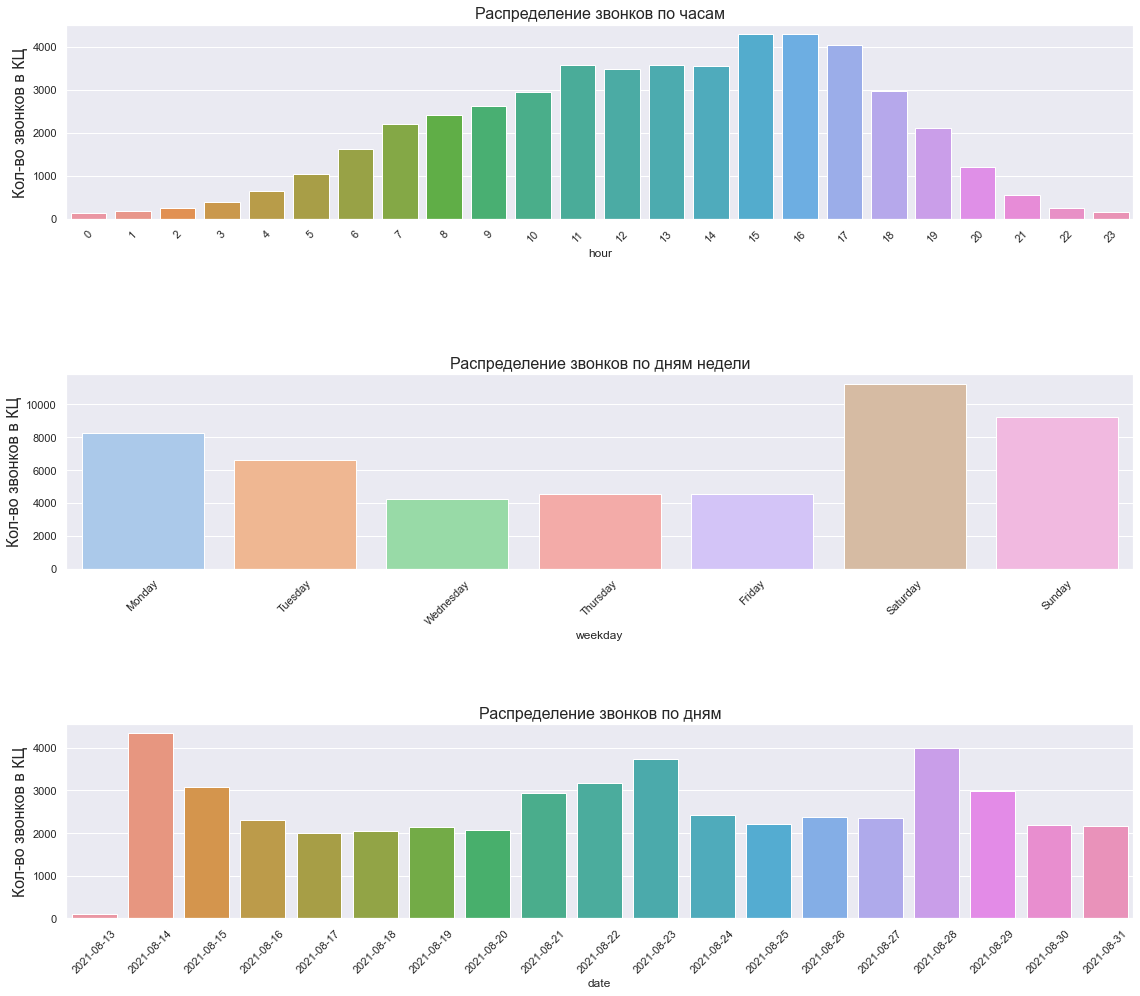

In [20]:
f, axes = plt.subplots(3, 1, figsize=(14, 10))

sns.countplot(data = df, x = df.groupby('call_id')['hour'].min(), ax=axes[0])

axes[0].set_title("Раcпределение звонков по часам", fontsize = 16)
axes[0].set_ylabel("Кол-во звонков в КЦ", fontsize = 16)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 45)

sns.countplot(data = df, x = df.groupby('call_id')['weekday'].min()
              ,order = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday'
                        , 'Saturday', 'Sunday'], ax=axes[1])

axes[1].set_title("Раcпределение звонков по дням недели", fontsize = 16)
axes[1].set_ylabel("Кол-во звонков в КЦ", fontsize = 16)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 45)

sns.countplot(data = df, x = df.groupby('call_id')['date'].min(), ax=axes[2])
axes[2].set_title("Раcпределение звонков по дням", fontsize = 16)
axes[2].set_ylabel("Кол-во звонков в КЦ", fontsize = 16)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 45)

plt.tight_layout()
f.subplots_adjust(hspace=0.8)
plt.show()

### ***Какой процент звонящих проходит из IVR в очередь? Из очереди к оператору?***

In [27]:
calls_on_ivr = df.query('verb == "INFO"')['call_id'].nunique()
calls_in_line = df.query('verb == "ENTERQUEUE"')['call_id'].nunique()
calls_to_agent = df.query('verb == "CONNECT"')['call_id'].nunique()

print(f'Процент звонков перешедших из IVR в очередь: {round((calls_in_line/ calls_on_ivr)*100,2)}%')
print(f'Процент звонков перешедших из очереди к оператору: {round((calls_to_agent/ calls_in_line)*100,2)}%')

Процент звонков перешедших из IVR в очередь: 51.71%
Процент звонков перешедших из очереди к оператору: 87.63%


### ***Какой процент звонящих ждал ответа меньше 20 секунд?***

In [28]:
call_less20 = (len(df.query('queue_duration < 20.0'))/calls_in_line)*100
print(f'Процент звонящих на удержании более 20 сек: {round(call_less20,3)}%')

Процент звонящих на удержании более 20 сек: 53.059%


### ***СРЕДНЕЕ ВРЕМЯ ЗВОНКОВ***

Проанализировав описательную статистику СВЗ график продолжительности СВЗ по дням, можно предположить следующее:

динамика довольно стабильная, если сравнить значения min, mean, max и квартилей.
резкий пик 13.08. возможно говорит о каком- то выбросе, который увелил метрику СВЗ;

In [29]:
df.groupby(['date'])['call_duration'].mean().describe()

count     19.000000
mean     377.118371
std       64.150695
min      308.083958
25%      353.200809
50%      367.536866
75%      379.091980
max      613.458333
Name: call_duration, dtype: float64

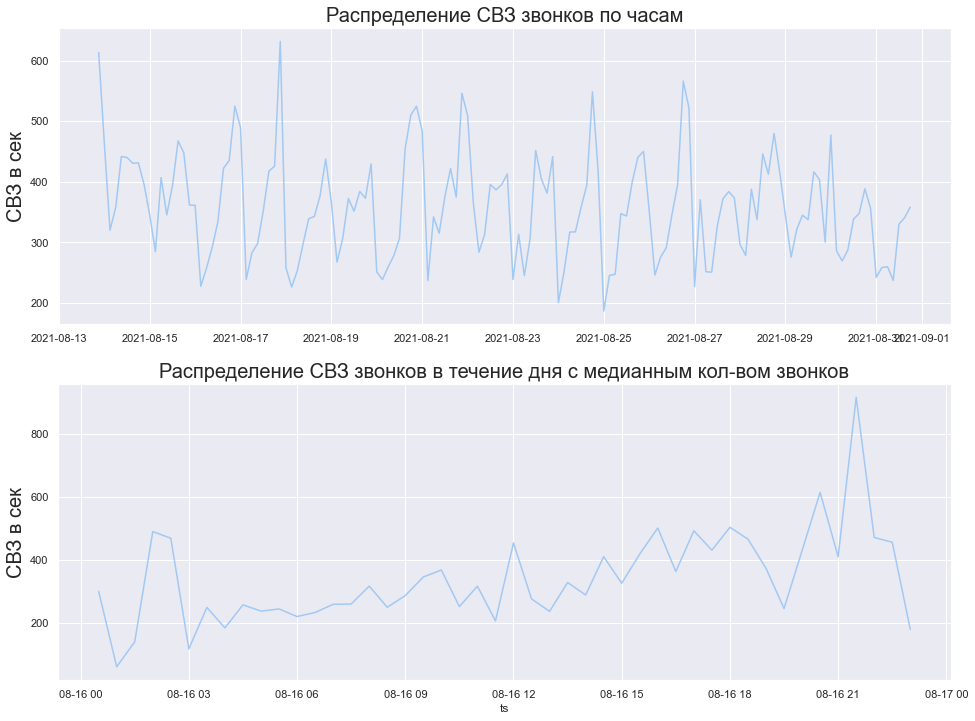

<Figure size 720x432 with 0 Axes>

In [38]:
f, axes = plt.subplots(2,1, figsize=(16, 12))
plt.figure(figsize=(10,6))

sns.lineplot(data = df.resample('3h', on = 'ts')['call_duration'].mean(), ax=axes[0])
axes[0].set_title('Распределение СВЗ звонков по часам', fontsize = 20)
axes[0].set_ylabel('СВЗ в сек', fontsize = 20)
axes[0].set_xlabel('')



sns.lineplot(data = df.query("ts >='2021-08-16 00:00:00' and ts < '2021-08-17 00:00:00'")\
                            .resample('30min', on = 'ts')['call_duration'].mean(), ax=axes[1])
axes[1].set_title('Распределение СВЗ звонков в течение дня c медианным кол-вом звонков', fontsize = 20)
axes[1].set_ylabel('СВЗ в сек', fontsize = 20)
f.subplots_adjust(hspace=0.2)
plt.tight_layout()

In [28]:
df.groupby(['date'],  as_index=False)['call_duration'].mean()

,date,call_duration
0,2021-08-13,613.458333
1,2021-08-14,418.423300
2,2021-08-15,408.135075
3,2021-08-16,353.128033
4,2021-08-17,367.536866
5,2021-08-18,324.284103
6,2021-08-19,356.601436
7,2021-08-20,363.387192
8,2021-08-21,371.727341
9,2021-08-22,370.437373


### ***Среднее время звонков на удержании***

In [89]:
# найдем сначала id звонков в ивентах которых находятся CALLERONHOLD и CALLEROFFHOLD т.е. эти звонки точно ставились на удержание.

onhold = df.query("verb == 'CALLERONHOLD' or verb == 'CALLEROFFHOLD'").\
                        groupby('call_id')['call_id'].count().\
                        to_frame().rename(columns ={'call_id': 'qty'}).\
                        reset_index()

on_hold_df = df[df['call_id'].isin(onhold['call_id'].to_list())]

In [119]:
#посчитаем СВЗ по каждому оператору в разрезе часа
oh_hold_mean_duration = on_hold_df.query('agent != "0"').groupby(['agent', 'hour']).\
                                agg({'call_duration':'mean'}).round(2).\
                                rename(columns = {'call_duration': 'mean_call_duration'}).reset_index()
oh_hold_mean_duration.set_index('agent')

,hour,mean_call_duration
agent,,
1,1,NaN
1,2,114.67
1,4,169.00
1,18,393.89
1,19,370.18
...,...,...
71,10,507.00
71,11,355.33
71,12,277.00


In [120]:
oh_hold_mean_duration.describe()

,agent,hour,mean_call_duration
count,515.000000,515.000000,479.000000
mean,31.885437,13.198058,822.209186
std,19.433326,5.395956,477.939730
min,1.000000,0.000000,63.000000
25%,14.000000,9.000000,533.245000
50%,30.000000,14.000000,728.000000
75%,46.000000,18.000000,1002.510000
max,71.000000,23.000000,3248.000000


### ***Среднее время удержания***

In [125]:
# найдем время удержания для каждого звонка, если оно было
df['hold_time'] = df.query("verb == 'CALLERONHOLD' or verb == 'CALLEROFFHOLD'").sort_values('ts', ascending = False).groupby(['call_id'])['ts'].diff(-1).dt.seconds.dropna(0)

In [126]:
df.query('call_id == "1629218307.216219"').sort_values('time')

,call_id,time_id,agent,verb,data,call_duration,queue_duration,ts,date,weekday,time,hour,hold_time
260491,1629218307.216219,1629218307,0,INFO,IVRSTART,NaN,NaN,2021-08-17 16:38:27,2021-08-17,Tuesday,16:38:27,16,NaN
260484,1629218307.216219,1629218325,0,INFO,IVRAPPEND,NaN,NaN,2021-08-17 16:38:45,2021-08-17,Tuesday,16:38:45,16,NaN
260480,1629218307.216219,1629218338,0,INFO,IVRAPPEND,NaN,NaN,2021-08-17 16:38:58,2021-08-17,Tuesday,16:38:58,16,NaN
260470,1629218307.216219,1629218351,0,INFO,IVRAPPEND,NaN,NaN,2021-08-17 16:39:11,2021-08-17,Tuesday,16:39:11,16,NaN
260461,1629218307.216219,1629218380,0,INFO,IVRAPPEND,NaN,NaN,2021-08-17 16:39:40,2021-08-17,Tuesday,16:39:40,16,NaN
260454,1629218307.216219,1629218395,0,ENTERQUEUE,NaN,NaN,NaN,2021-08-17 16:39:55,2021-08-17,Tuesday,16:39:55,16,NaN
260455,1629218307.216219,1629218395,0,INFO,IVRGOAL,NaN,NaN,2021-08-17 16:39:55,2021-08-17,Tuesday,16:39:55,16,NaN
260405,1629218307.216219,1629218554,31,CONNECT,159,NaN,NaN,2021-08-17 16:42:34,2021-08-17,Tuesday,16:42:34,16,NaN
260121,1629218307.216219,1629219582,0,CALLERONHOLD,okko,NaN,NaN,2021-08-17 16:59:42,2021-08-17,Tuesday,16:59:42,16,NaN
425922,1629218307.216219,1629219745,0,CALLEROFFHOLD,NaN,NaN,NaN,2021-08-17 17:02:25,2021-08-17,Tuesday,17:02:25,17,163.0


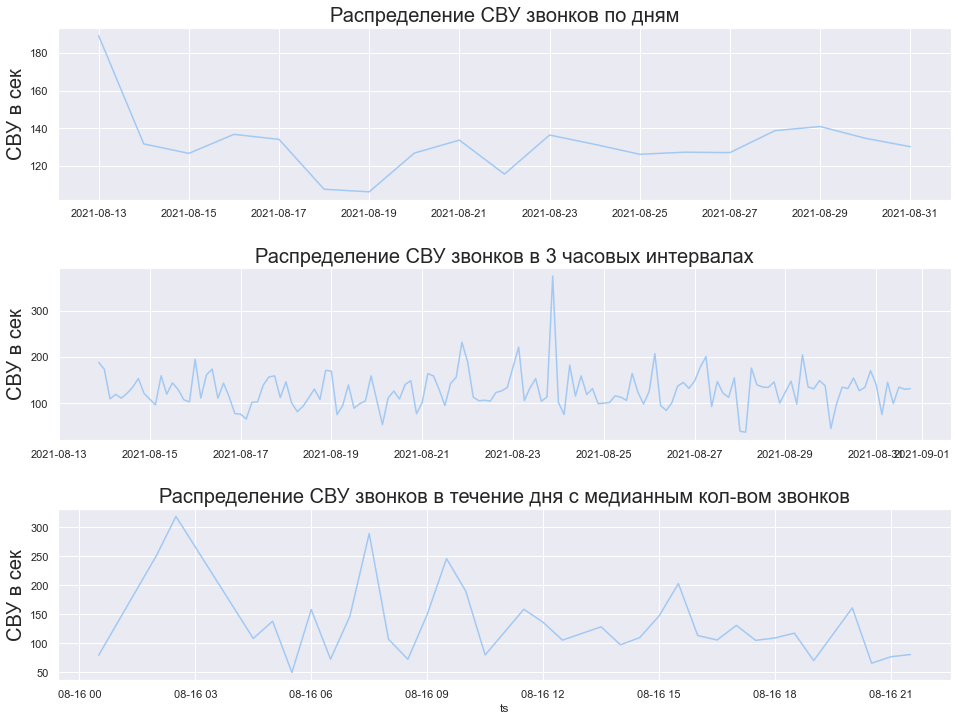

<Figure size 720x432 with 0 Axes>

In [138]:
f, axes = plt.subplots(3,1, figsize=(16, 12))
plt.figure(figsize=(10,6))

sns.lineplot(data = df.resample('1d', on = 'ts')['hold_time'].mean(),ax=axes[0])
axes[0].set_title('Распределение СВУ звонков по дням', fontsize = 20)
axes[0].set_ylabel('СВУ в сек', fontsize = 20)
axes[0].set_xlabel('')

sns.lineplot(data = df.resample('3h', on = 'ts')['hold_time'].mean(),ax=axes[1])
axes[1].set_title('Распределение СВУ звонков в 3 часовых интервалах', fontsize = 20)
axes[1].set_ylabel('СВУ в сек', fontsize = 20)
axes[1].set_xlabel('')

sns.lineplot(data = df.query("ts >='2021-08-16 00:00:00' and ts < '2021-08-17 00:00:00'")\
                            .resample('30min', on = 'ts')['hold_time'].mean(), ax=axes[2])
axes[2].set_title('Распределение СВУ звонков в течение дня c медианным кол-вом звонков', fontsize = 20)
axes[2].set_ylabel('СВУ в сек', fontsize = 20)
f.subplots_adjust(hspace=0.4)
plt.tight_layout()

***Соберем агрегированную статистику по звонкам - call_id, время начала звонка, время выхода из ivr, время входа в очередь, время присоединения к оператору, имя оператора, время завершения звонка, длительность звонка и время ожидания в очереди, и загрузим в БД***

In [139]:
stats = df.query('verb == "INFO"').groupby(['call_id']).agg({'ts':'min'})\
                                     .sort_values('call_id').reset_index()\
                                     .rename(columns ={'ts':'call_start'})

In [140]:
ivr_out = df.query('data == "IVRGOAL"').groupby(['call_id']).agg({'ts':'min'})\
                             .sort_values('call_id').reset_index()\
                             .rename(columns ={'ts':'ivr_out_time'})

stats =stats.merge(ivr_out, how = 'left', on='call_id')

In [141]:
queue_in = df.query('verb == "ENTERQUEUE"').groupby(['call_id']).agg({'ts':'min'})\
                                           .sort_values('call_id').reset_index()\
                                           .rename(columns ={'ts':'queue_in'})

stats = stats.merge(queue_in, how = 'left', on='call_id')

In [142]:
op_connect = df.query('verb == "CONNECT"').groupby(['call_id','agent']).agg({'ts':'min'})\
                                          .sort_values('call_id').reset_index()\
                                          .rename(columns ={'ts':'op_connect_time'})

stats = stats.merge(op_connect, how = 'left', on='call_id')

In [143]:
call_end = df.query('verb == "COMPLETECALLER" or verb == "COMPLETEAGENT"')\
             .groupby(['call_id']).agg({'ts':'min'}).sort_values('call_id')\
             .reset_index().rename(columns ={'ts':'call_end_time'})

stats = stats.merge(call_end, how = 'left', on='call_id')

In [144]:
call_duration = df.groupby(['call_id']).agg({'call_duration':'min'})\
                                       .sort_values('call_id').reset_index()

stats = stats.merge(call_duration, how = 'left', on='call_id')

In [145]:
queue_duration = df.groupby(['call_id']).agg({'queue_duration':'min'})\
                                        .sort_values('call_id').reset_index()

stats = stats.merge(queue_duration, how = 'left', on='call_id')

In [146]:
stats[['agent','call_duration','queue_duration']] = stats[['agent','call_duration','queue_duration']].fillna(0)
stats[['agent','call_duration','queue_duration']] = stats[['agent','call_duration','queue_duration']].astype(int)

In [147]:
import sqlite3

try:
    connector = sqlite3.connect('C:/Users/Zag-zag/Desktop/DSDA/call_centre.db')
    cursor = connector.cursor()
    print("База данных создана и успешно подключена к SQLite")
    query = """CREATE TABLE IF NOT EXISTS calls_aggregated(
                        call_id BLOB,
                        call_start INTEGER,
                        ivr_out_time INTEGER,
                        queue_in INTEGER,
                        agent INTEGER,
                        op_connect_time INTEGER,
                        call_end_time INTEGER,
                        call_duration INTEGER,
                        queue_duration INTEGER);"""
    cursor.execute(query)
    connector.commit()
    print("Таблица calls_aggregated создана")
    
except sqlite3.Error as error:
    print("Ошибка при работе с SQLite", error)
finally:
        if connector:
                connector.close()
                print("Соединение с SQLite закрыто")         

База данных создана и успешно подключена к SQLite
Таблица calls_aggregated создана
Соединение с SQLite закрыто


In [148]:
connector = sqlite3.connect('C:/sqlite/call_center.db')
stats.to_sql('calls_aggregated', connector, if_exists='replace', index = False)
print("Записи успешно вставлены в таблицу calls_aggregated")

Записи успешно вставлены в таблицу calls_aggregated


In [149]:
#проверка
connector = sqlite3.connect('C:/sqlite/call_center.db')
fetch_query ="""SELECT *
                FROM calls_aggregated
                LIMIT 10;
                """ 
pd.read_sql(fetch_query, connector)

,call_id,call_start,ivr_out_time,queue_in,agent,op_connect_time,call_end_time,call_duration,queue_duration
0,1628888314.178566,2021-08-13 21:00:02,2021-08-13 21:00:02,2021-08-13 21:00:02,64,2021-08-13 21:00:07,2021-08-13 21:02:49,162,5
1,1628888363.178569,2021-08-13 21:00:11,2021-08-13 21:00:11,2021-08-13 21:00:11,38,2021-08-13 21:00:17,2021-08-13 21:24:15,1438,6
2,1628888440.178594,2021-08-13 21:00:40,2021-08-13 21:01:03,2021-08-13 21:01:03,60,2021-08-13 21:01:05,2021-08-13 21:21:43,1238,2
3,1628888450.178597,2021-08-13 21:00:50,2021-08-13 21:01:42,2021-08-13 21:01:42,9,2021-08-13 21:01:47,2021-08-13 21:06:32,285,5
4,1628888474.178603,2021-08-13 21:01:14,2021-08-13 21:02:38,2021-08-13 21:02:38,8,2021-08-13 21:02:48,2021-08-13 21:14:07,679,10
5,1628888591.178636,2021-08-13 21:03:11,2021-08-13 21:04:53,2021-08-13 21:04:53,57,2021-08-13 21:04:56,2021-08-13 21:16:25,689,3
6,1628888658.178645,2021-08-13 21:04:18,2021-08-13 21:05:49,2021-08-13 21:05:49,15,2021-08-13 21:05:53,2021-08-13 21:10:04,251,4
7,1628888663.178648,2021-08-13 21:04:23,2021-08-13 21:05:51,2021-08-13 21:05:51,64,2021-08-13 21:05:57,2021-08-13 21:08:40,163,6
8,1628888663.178649,2021-08-13 21:04:23,None,None,0,None,None,0,0
9,1628888701.178662,2021-08-13 21:05:01,2021-08-13 21:06:20,2021-08-13 21:06:20,1,2021-08-13 21:08:39,2021-08-13 21:09:45,66,139
